In [1]:
!pip install pylsd
!pip install 'ocrd-fork-pylsd == 0.0.3'

     |████████████████████████████████| 44 kB 519 kB/s eta 0:00:011
  Created wheel for pylsd: filename=pylsd-0.0.2-py3-none-any.whl size=46364 sha256=4ff2fff4abb340b93849fc394cd6026cba0935b860355ec85be6a4ddae8ca318
  Stored in directory: /Users/nakamurasatoru/Library/Caches/pip/wheels/9b/63/9d/790450d057de8c5fc9ed261526ce13048db7e365ef5f53ca0e
Successfully built pylsd
     |████████████████████████████████| 47 kB 514 kB/s eta 0:00:011


In [9]:
!pip install gdown

In [12]:
!gdown "https://drive.google.com/uc?id=1lu739RJi0wNQ5neWJ71zzaDVZqhvjoE5"

Downloading...
From: https://drive.google.com/uc?id=1lu739RJi0wNQ5neWJ71zzaDVZqhvjoE5
To: /Users/nakamurasatoru/git/d_nijl/ruler/best.pt
100%|█████████████████████████████████████████| 173M/173M [10:28<00:00, 276kB/s]


In [28]:
key = "kyoto"

####

collection = {
    "sat": {
        "url" : "https://candra.dhii.jp/iipsrv/iipsrv.fcgi?IIIF=/kakouzou_pub/001_1/0001s.tif/full/full/0/default.jpg"
    },
    "nijl": {
        "url" : "https://kotenseki.nijl.ac.jp/api/iiif/100302677/v4/KANS/KANS-00281/KANS-00281-00002.tif/full/full/0/default.jpg"
    },
    "kyoto": {
        "iiif" : "https://rmda.kulib.kyoto-u.ac.jp/iiif/RB00020027/RB00020027_00001_0.ptif/16512,327,1872,1200/full/0/default.jpg"
    },
    "kyushu": {
        "url" : "https://catalog.lib.kyushu-u.ac.jp/image/iiif/820/1467768/467234.tiff/full/full/0/default.jpg"
    }
}

#####

item = collection[key]

if "iiif" in item:
  url = item["iiif"]
  type = "iiif"
else:
  url = item["url"]
  type = "url"
    
!python load.py $url $type

入力画像サイズ: 1872 px x 1200 px


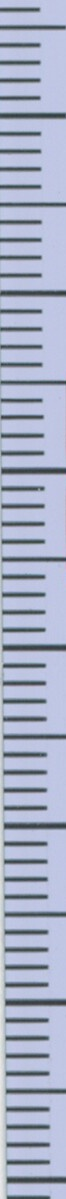

NameError: name 'isHorizontal' is not defined

In [17]:
!python main.py 

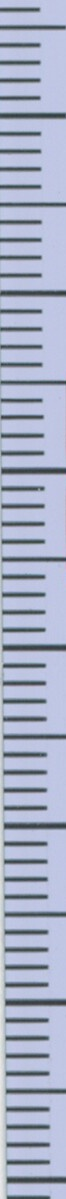

In [16]:
def detect(show=True):

  from PIL import Image
  image_size = 1024
  img = Image.open(filename)
  w, h = img.size

  # 長い辺
  ll = max(w, h)

  # 1024以下の場合がある
  yolo_input_size = min(image_size, ll)

  resized = img

  r2 = 1

  # 大きい場合には、小さくする
  if ll > image_size:
      r2 = image_size / ll
      resized = resized.resize((int(w * r2), int(h * r2)))

  results = model(resized, size=yolo_input_size)

  data = results.pandas().xyxy[0].to_json(orient="records")
  data = json.loads(data)

  # print("検出された物体の数", len(data))

  # ダウンロードした画像がmaxを超える場合がある
  # r = max(c_width, c_height) / yolo_input_size
  r = 1

  score_max = 0

  for i in range(len(data)):
      obj = data[i]

      score = obj["confidence"]

      if score_max > score:
        continue

      score_max = score

      index = i + 1

      x = int(obj["xmin"] * r / r2)
      y = int(obj["ymin"] * r / r2)
      w = int(obj["xmax"] * r / r2) - x
      h = int(obj["ymax"] * r / r2) - y

      xywh = "{},{},{},{}".format(x, y, w, h)

      opath = "ruler.jpg"

      im_crop = img.crop((x, y, x + w, y + h))
      im_crop.save(opath, quality=95)

      if show:
        from IPython.display import Image,display_jpeg
        display_jpeg(Image(opath))

  return len(data)

size = detect(True)

In [18]:
def isHorizontal():
  opath = "ruler.jpg"
  img = cv2.imread(opath)
  w = img.shape[1]
  h = img.shape[0]

  horizontal = True
  if h > w:
    horizontal = False

  return horizontal

horizontal = isHorizontal()
print("horizontal", horizontal)

horizontal False


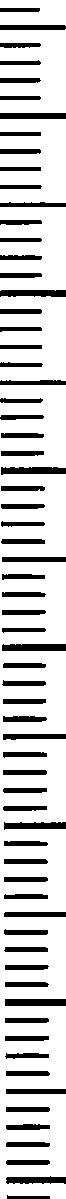

In [19]:
def otsu(show=False):
  opath = "ruler.jpg"
  from IPython.display import Image,display_jpeg
  img = cv2.imread(opath)
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  ret2, img_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

  otsu_path = "otsu.jpg"
  cv2.imwrite(otsu_path, img_otsu)

  if show:
    display_jpeg(Image(otsu_path))

otsu(True)

In [26]:
!pip install opencv-contrib-python

     |████████████████████████████████| 54.8 MB 431 kB/s eta 0:00:01     |████████████████▌               | 28.2 MB 520 kB/s eta 0:00:52


In [27]:
def skelton(show=False):

  otsu_path = "otsu.jpg"

  from IPython.display import Image,display_jpeg

  img = cv2.imread(otsu_path)

  # グレー
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # 二値画像反転
  image = cv2.bitwise_not(gray)

  # 細線化(スケルトン化) THINNING_ZHANGSUEN
  skeleton1   =   cv2.ximgproc.thinning(image, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
  skeleton_path = "skeleton.jpg"
  cv2.imwrite(skeleton_path, skeleton1)

  if show:
    display_jpeg(Image(skeleton_path))

skelton(True)

AttributeError: module 'cv2' has no attribute 'ximgproc'

In [21]:
def hlsd(horizontal, show=False):

  img = cv2.imread(opath)
  gray = cv2.imread('skeleton.jpg', 0)

  w = img.shape[1] if horizontal else img.shape[0]
  h = img.shape[0] if horizontal else img.shape[1]

  img4 = img.copy()

  lines = lsd(gray)

  x = []
  y = []

  for i in range(w):
    x.append(i)
    y.append(0)

  for i in range(lines.shape[0]):
    pt1 = (int(lines[i, 0]), int(lines[i, 1]))
    pt2 = (int(lines[i, 2]), int(lines[i, 3]))

    if horizontal:
      dx = int((int(lines[i, 0]) +  int(lines[i, 2])) / 2)
      dy = int(lines[i, 3]) - int(lines[i, 1])
    else:
      dx = int((int(lines[i, 1]) +  int(lines[i, 3])) / 2)
      dy = int(lines[i, 2]) - int(lines[i, 0])

    width = lines[i, 4]
    cv2.line(img4, pt1, pt2, (0, 255, 0), int(np.ceil(width / 2)))

    y[dx] = dy  

  cv2.imwrite('img4.jpg',img4)
  if show:
    from IPython.display import Image,display_jpeg
    display_jpeg(Image('img4.jpg'))

  x = np.array(x)
  y = np.array(y)

  return x, y

x, y = hlsd(horizontal, True)

NameError: name 'opath' is not defined

In [22]:
def arg_r(x, y, show=False):
  
  arg_r_min,arg_r_max=argrelmin(y),argrelmax(y)

  if show:
    fig, ax = plt.subplots(dpi=130)
    ax.plot(x,y,"C2-")
    ax.plot(x[arg_r_min[0]],y[arg_r_min[0]],"ro",label="argrelmin")
    ax.plot(x[arg_r_max[0]],y[arg_r_max[0]],"mo",label="argrelmax")
    plt.legend()
    ax.set(xlabel="bins",ylabel="Frequency")
    plt.tight_layout()
    plt.savefig("arg_rel_minmax2.png",dpi=130)
    plt.show()

  return arg_r_max

arg_r_max = arg_r(x, y, True)

NameError: name 'x' is not defined

In [23]:
def check(horizontal, arg_r_max, showFlag):
  skeleton_path = "skeleton.jpg"
  
  blue = cv2.imread(skeleton_path)

  if horizontal:
    h, w, z = blue.shape 
  else:
    w, h, z = blue.shape

  for x1 in x[arg_r_max[0]]:
    if horizontal:
      blue = cv2.line(blue, (x1,int(h * 2/3)), (x1,h), (0,255,0), 1)
    else:
      blue = cv2.line(blue, (int(h * 2 / 3), x1), (h, x1), (0,255,0), 1)

  output_path = "blue.jpg"
  cv2.imwrite(output_path, blue)
  if showFlag:
    from IPython.display import Image,display_jpeg
    display_jpeg(Image(output_path))

check(horizontal, arg_r_max, True)

NameError: name 'arg_r_max' is not defined

In [24]:
def output(arg_r_max, horizontal, show=False):
  opath = "ruler.jpg"
  img = cv2.imread(opath)

  if horizontal:
    img_h, img_w, z = img.shape 
  else:
    img_w, img_h, z = img.shape
  # img_w, img_h, img_z = img.shape

  x0 = 0

  map2 = {}

  l = []

  for x1 in x[arg_r_max[0]]:

    # if x1 < 77:
    # red_line_img = cv2.line(img, (x1,0), (x1,h), (0,0,255), 3)

    d = x1 - x0
    if d not in map2:
      map2[d] = 0

    # map2[w] += 1

    x0 = x1

    l.append(d)


  # cv2.imwrite(output_path, red_line_img)
  # display_jpeg(Image(output_path))

  # print(map2)

  
  median = int(statistics.median(l) * 10) # 中央値
  # print("median", median)
  median = int(statistics.mode(l) * 10) # 最頻値
  # print("mode", median)
  # median = int(statistics.mode(l) * 1)

  # print(median)

  flg = True

  x_s = 0

  while flg:
    if horizontal:
      red_line_img = cv2.line(img, (x_s,0), (x_s,img_h), (255,0,0), 3)
    else:
      red_line_img = cv2.line(img, (0, x_s), (img_w, x_s), (255,0,0), 3)

    x_s += median

    if x_s > img_w:
      flg = False

  output_path = "output.jpg"
  cv2.imwrite(output_path, red_line_img)

  if show:
    from IPython.display import Image,display_jpeg
    display_jpeg(Image(output_path))

  return {
      "width" : img_w if horizontal else img_h,
      "height" : img_h if horizontal else img_w,
      "pixelPerMM" : int(median / 10)
  }

value = output(arg_r_max, horizontal, True)
print(value)

NameError: name 'arg_r_max' is not defined

In [25]:
def resize(url):
  # image_api = "https://rmda.kulib.kyoto-u.ac.jp/iiif/RB00020027/RB00020027_00001_0.ptif/info.json"

  spl = url.split("/")

  ###

  ln = spl[-4] + "/" + spl[-3] + "/" + spl[-2] + "/" + spl[-1]
  api = url.replace(ln, "info.json")

  df = requests.get(api).json()
  full_image_width = df["width"]
  full_image_height = df["height"]

  ###

  xywh = spl[-4].split(",")

  input_image_width = int(xywh[2])
  input_image_height = int(xywh[3])

  ###

  full_width =  input_image_w * (full_image_width / input_image_width)
  full_height =  input_image_h * (full_image_height / input_image_height)

  print("（追加）フル画像の実サイズ: {} mm x {} mm".format(int(full_width), int(full_height)))

resize(url)

NameError: name 'input_image_w' is not defined